In this Notebook we see how we can use an LSTM as a many to one model that takes in a sequence of data and provides a single output at the end of the sequence.<br>
As an example we use the MNIST dataset and "patchify" it, splitting the image into a sequence of patches and passing them to the model one patch at a time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
import torchvision

from tqdm import trange, tqdm

In [2]:
# The size of our mini batches
batch_size = 128

# How many itterations of our dataset
num_epochs = 50

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "."

device = torch.device(0 if torch.cuda.is_available() else 'cpu')

In [15]:
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

In [16]:
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [18]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

In [19]:
# Function to turn a batch of images into a sequence of patches

def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxCx8x8, where L is the number of patches in each dimension
    # For each dimension, number of patches = (original dimension size) // patch_size
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c, patch_size, patch_size)
    
    return unfolded

In [20]:
dataiter = next(iter(test_loader))
# Sample from the itterable object
test_images, test_labels = dataiter

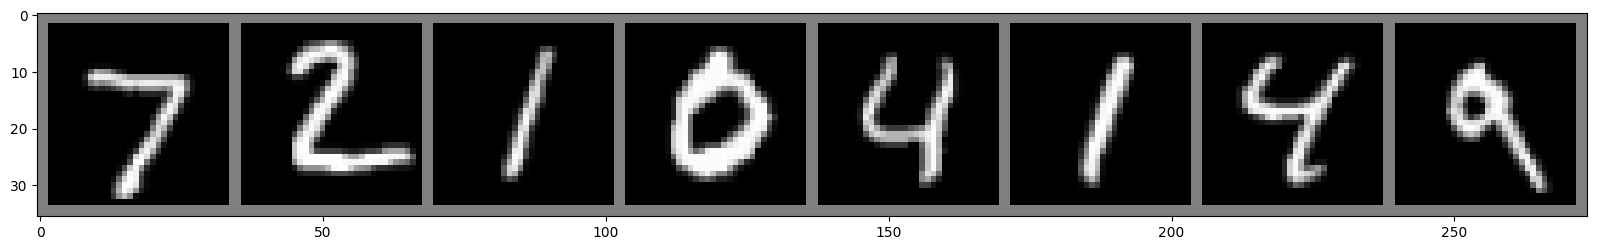

In [21]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

torch.Size([128, 16, 1, 8, 8])
Sequence Length 16
torch.Size([16, 1, 8, 8])


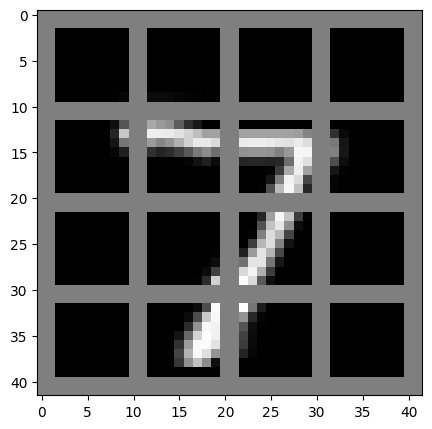

In [22]:
# Set the patch size for extraction
patch_size = 8

# Extract patches from the test images using the defined function
patches = extract_patches(test_images, patch_size=patch_size)

print(patches.shape)

# Calculate the grid size for visualization
grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

print(patches[0].shape)
# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches[0], grid_size, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))


### Create Image Patch LSTM
This model uses an LSTM network for sequential image data processing. It divides input images into patches and then feeds them into the LSTM layer for sequential analysis. Residual blocks are incorporated within the LSTM to enhance gradient flow and capture temporal dependencies. Finally, the output is passed through a fully connected layer for prediction.

In [37]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(ResBlockMLP, self).__init__()
        
        # Define layer normalization for input size
        self.norm1 = nn.LayerNorm(input_size)
        
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        # Layer normalization for input size // 2
        self.norm2 = nn.LayerNorm(input_size//2)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        # Final fully connected layer
        self.fc3 = nn.Linear(input_size, output_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply layer normalization and activation function
        x = self.act(self.norm1(x))
        # Calculate skip connection
        skip = self.fc3(x)
        
        # Apply layer normalization, fully connected layer, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        # Add skip connection
        return x + skip


# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, output_size=10, patch_size=4, lstm_layers=1, hidden_size=64, num_blocks=1):
        super(LSTM, self).__init__()
        
        # Define a fully connected layer for input data
        self.fc_in = nn.Linear(patch_size**2, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=lstm_layers, batch_first=True)
              
        # Define residual blocks
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        
        # Activation function
        self.act = nn.ELU()
        self.patch_size = patch_size

    def forward(self, input_data, hidden_in, mem_in): # input = (128, 1, 32, 32), (4, 128, 128), (4, 128, 128) for (layers, bs, hidden)
        
        # Turn the images into a sequence of patches which will be passed to the model one at a time
        bs, c, h, w = input_data.shape
        input_seq = extract_patches(input_data, self.patch_size).reshape(bs, -1, self.patch_size**2) # (bs, l, patch_size * patch_size) = (128, 64, 16)

        # Linear layer
        x = self.act(self.fc_in(input_seq)) # (128, 64, 128) (bs, patches, hidden)
        
        # The LSTM will process the sequence of patches sequentially
        output, (hidden_out, mem_out) = self.lstm(x, (hidden_in, mem_in))

        # output - (128, 64, 32)
        # hidden_out = (4, 128, 32)
        # mem_out = (4, 128, 32)

        # We'll get an output from the model from every time-step but we'll only calculate the loss at the last timestep
        x  = self.act(self.res_blocks(output))

        # x = (128, 64, 32)

        return self.fc_out(x), hidden_out, mem_out
        # x = (128, 64, 10)

In [38]:
lstm_layers = 4

hidden_size = 32

mnist_lstm = LSTM(output_size = 10, patch_size=patch_size, 
                  lstm_layers=lstm_layers, hidden_size=hidden_size).to(device)

optimizer = optim.Adam(mnist_lstm.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()  

training_loss_logger = []
training_acc_logger = []
valid_loss_logger = []
valid_acc_logger = []

In [39]:
for data, label in train_loader:
    print(data.shape)
    break

torch.Size([128, 1, 32, 32])


In [41]:
train_acc = 0
valid_acc = 0

for epoch in range(num_epochs):

    # Set the model to training mode
    mnist_lstm.train()
    train_acc = 0
    
    # Iterate through the training data loader
    for data, label in train_loader:
        
        # Move data and labels to the appropriate device
        data = data.to(device)
        label = label.to(device)
        
        # Initialize the hidden states and memory buffers with zeros
        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device) # (4, 128, 32)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device) # (4, 128, 32)
        
        # Forward pass through the model
        data_pred, hidden, memory = mnist_lstm(data, hidden, memory) # (128, 16, 10)

        
        # Select the output from the last time step for calculating loss
        last_target = data_pred[:, -1, :] # (128, 10)

        # Calculate the loss
        loss = loss_fn(last_target, label) # (128, 10) & (128)
            
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log training loss and calculate training accuracy
        training_loss_logger.append(loss.item())
        train_acc += (last_target.argmax(1) == label).sum()
        
    # Calculate and log training accuracy
    train_acc = (train_acc/len(train_data)).item() # Divide over total number of examples
    training_acc_logger.append(train_acc)
        
    # Set the model to evaluation mode
    mnist_lstm.eval()
    valid_acc = 0
    
    # Validate the model
    with torch.no_grad():
        # Iterate through the validation data loader
        for data, label in valid_loader:
            # Move data and labels to the appropriate device
            data = data.to(device)
            label = label.to(device)

            # Initialize the hidden states and memory buffers with zeros
            hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
            memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

            # Forward pass through the model
            data_pred, hidden, memory = mnist_lstm(data, hidden, memory)
            
            # Select the output from the last time step for calculating loss
            last_target = data_pred[:, -1, :]

            # Calculate the loss
            loss = loss_fn(last_target, label)
            
            # Log validation loss and calculate validation accuracy
            valid_loss_logger.append(loss.item())
            valid_acc += (last_target.argmax(1) == label).sum() # (128, 10) -> (128) & (128) -> (1)
            
    # Calculate and log validation accuracy
    valid_acc = (valid_acc/len(valid_data)).item()
    valid_acc_logger.append(valid_acc)

    print(f"loss: {loss.item()}")

loss: 1.5659630298614502


loss: 1.028598427772522


loss: 0.7297846078872681


loss: 0.5543680191040039


loss: 0.41561031341552734


loss: 0.33954310417175293


loss: 0.29122453927993774


loss: 0.23125971853733063


loss: 0.18053238093852997


loss: 0.18466879427433014


loss: 0.16718696057796478


loss: 0.16513991355895996


loss: 0.1519540250301361


loss: 0.14751014113426208


loss: 0.14989110827445984


loss: 0.14135859906673431


loss: 0.14867646992206573


loss: 0.14849035441875458


loss: 0.13538385927677155


KeyboardInterrupt: 

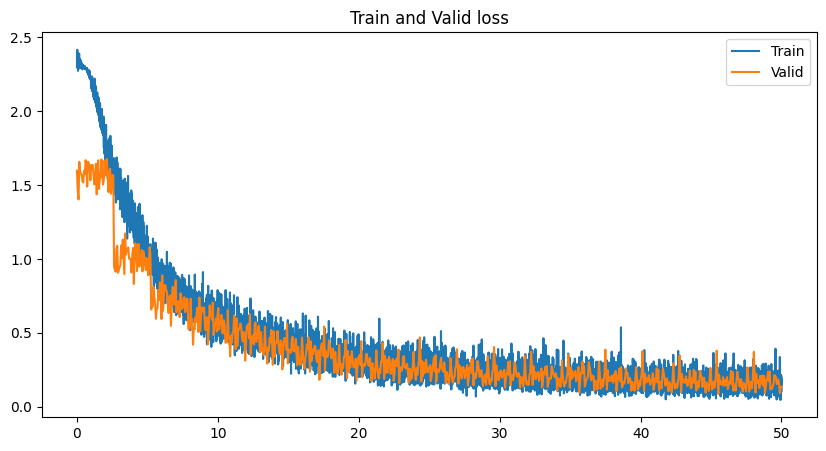

In [42]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid loss")
_ = plt.plot(np.linspace(0, num_epochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_loss_logger)), valid_loss_logger)

_ = plt.legend(["Train", "Valid"])

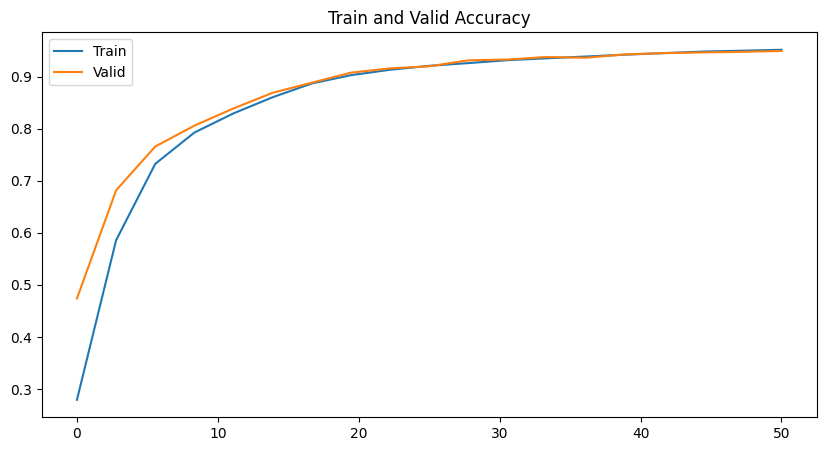

In [43]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid Accuracy")
_ = plt.plot(np.linspace(0, num_epochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_acc_logger)), valid_acc_logger)

_ = plt.legend(["Train", "Valid"])

In [46]:
for data, label in test_loader:
    print(data.shape)
    break

torch.Size([128, 1, 32, 32])


In [53]:
mnist_lstm.eval()
test_acc = 0
with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Testing", leave=False):
        data = data.to(device)
        label = label.to(device)

        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

        data_pred, hidden, memory = mnist_lstm(data, hidden, memory)
        last_target = data_pred[:, -1, :]

        test_acc += (last_target.argmax(1) == label).sum()
test_acc = (test_acc/len(test_data)).item()

print("Test Accuracy %.2f%%" % (test_acc * 100))

Test Accuracy 94.69%


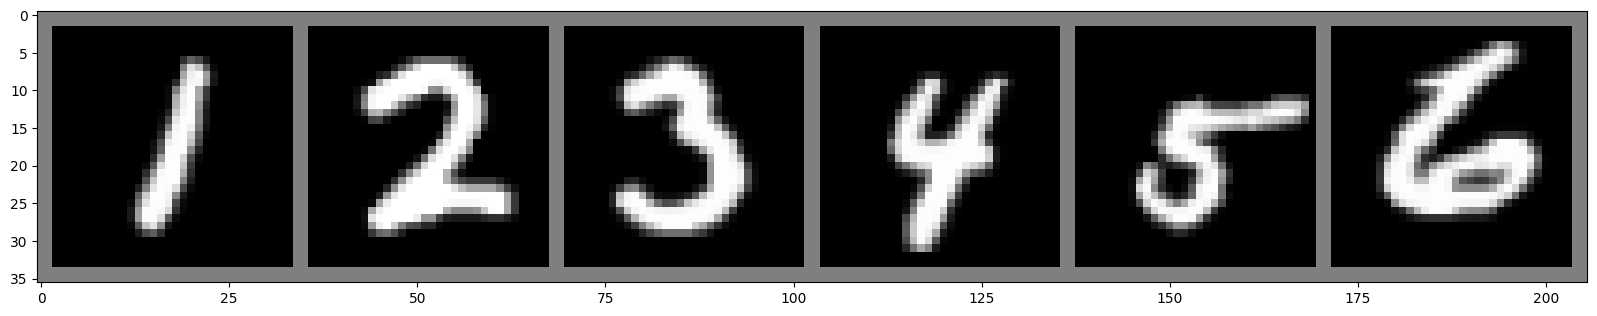

In [56]:
plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(data[10:18], 8, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [57]:
print(last_target[10:18].argmax(1))

tensor([1, 2, 3, 4, 5, 6])
